<img src="img/h++.png" alt="HELIOS++ Logo" width="200" align="right">

# An Introduction to LiDAR Simulation with HELIOS++

**II: UAV-borne laser scanning**

LiDAR simulation can be useful for multiple applications:
- Acquisition planning
- Method development and evaluation
- Training data generation (for machine learning)

<img src="img/lidar_sim.png" alt="Visualization of LiDAR Simulation" align="right" width="800">

In this notebook, we will simulate a UAV-borne LiDAR acquisition to demonstrate how HELIOS++ can be used for acquisition planning.

In [1]:
# Imports
import os
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib
import pyhelios
from pyhelios import SimulationBuilder
from pyhelios.util import flight_planner
import helper_funcs
import numpy as np
from osgeo import gdal
import rasterio as rio
import laspy

To execute LAStools commands, we need to provide the LAStools directory. This may be a different location on your computer, so you will have to provide the correct path:

In [2]:
# configure LAStools root
lastools_root = "C:/LAStools"

You can find a comprehensive documentation in the [HELIOS Wiki](https://github.com/3dgeo-heidelberg/helios/wiki).

## 1. The virtual scene

The first component of a simulation is the 3D input scene. HELIOS++ supports loading different file format, including Wavefront OBJ triangle meshes, GeoTIFF rasters or XYZ point clouds, which will be converted to voxel models. In this tutorial, we will use GeoTIFF for loading terrain and XYZ files for loading voxelized vegetation.

**Preparing the scene parts**

We will first get a spatial subset of the terrain model using `gdal_translate`.

*Note*: With the exclamation mark (`!`), we can issue a shell command and hence run the command line tools of GDAL and LAStools.

In [3]:
Path("data/output").mkdir(parents=True, exist_ok=True)
bbox = [20103.0, 312815.0, 20596.0, 312410.0]
terrain = "data/StA_last_dtm.tiff"
terrain_sub = "data/output/StA_last_filtered_sub.tiff"
!gdal_translate -projwin 20103.0 312815.0 20596.0 312410.0 $terrain $terrain_sub

Input file size is 801, 751
0...10...20...30...40...50...60...70...80...90...100 - done.


Using LAStools "las2txt", we convert the LAZ file of the study site to an ASCII file and extract only vegetation points, which have classification values of 0.

In [4]:
vegetation = "data/output/StA_last_vegetation.xyz"
!$lastools_root/bin/las2txt64.exe -i data/StA_last.laz -o $vegetation -keep_classification 0 -parse xyz

Using the same bounding box as above, we also extract a spatial subset of the vegetation points.

In [5]:
vegetation_sub = "data/output/StA_last_vegetation_sub.xyz"

vegetation_arr = np.loadtxt(vegetation)
idx_sub = (vegetation_arr[:, 0] > bbox[0]) & (vegetation_arr[:, 0] < bbox[2]) & (vegetation_arr[:, 1] > bbox[3]) & (vegetation_arr[:, 1] < bbox[1])
vegetation_arr_sub = vegetation_arr[idx_sub, :]
np.savetxt(vegetation_sub, vegetation_arr_sub, fmt="%.6f")

voxel_size = 0.25

**Writing the scene**

We now have the two files from which we will load the scene parts (stored in the Python variables `terrain_sub` and `vegetation_sub`). We have furthermore defined a `voxel_size` for voxelizing the vegetation points.

With this information, we can write the scene. HELIOS++ uses XML files for configuring scanners, platforms, surveys and scenes. Below, we write the scene XML file and fill in the values we defined before (`terrain_sub`, `vegetation_sub`, `voxel_size`). Note how each scene part is embedded in a `<part>` tag and uses a different "loader" `filter` depending on the file format.

In [6]:
# Writing the scene XML file
scene_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<document>
    <scene id="helios_scene" name="HELIOS scene">
        
        <part>
            <filter type="geotiffloader">
                <param type="string" key="filepath" value="{terrain_sub}" />
            </filter>
        </part>
        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="{vegetation_sub}" />
                <param type="string" key="separator" value=" " />
                <param type="double" key="voxelSize" value="{voxel_size}" />
            </filter>
        </part>
    </scene>
</document>
"""

In [7]:
# save scene file to the current directory
scene_file = "StA_helios_scene_small.xml"
with open(scene_file, "w") as f:
    f.write(scene_content)

## 2. Selection of platform and scanner

In the first scenario, we will select a UAV platform (copter). As scanner, we choose the "RIEGL VUX-1UAV-22".

Feel free to try out other scanners in [python/pyhelios/data/scanners_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/scanners_als.xml) but please notice that different scanner types require different survey specifications.

In [8]:
platform = "copter_linearpath"
scanner = "riegl_vux-1uav22"

## 3. Specification of the survey

**Waypoints (trajectory)**

We will use the `flight_planner` utility tool of HELIOS++ to easily generate a trajecotry. We also modify the waypoints with some helper functions to follow a height above the terrain.

In [9]:
height_agl = 120
bbox = [20250, 312450, 20550, 312700]
waypoints, centre, distance = flight_planner.compute_flight_lines(bounding_box=bbox,
                                               spacing=75,
                                               rotate_deg=-10,
                                               flight_pattern="parallel")
# add an additional point between the long flight lines
new_waypoints = helper_funcs.add_support_points(waypoints)
# add z-values to waypoints using a height above the terrain
waypoints_with_z = helper_funcs.waypoints_above_ground(new_waypoints, terrain_sub, height_agl)

Let's plot the resulting trajecotry on top of the terrain to see if it covers the study site well.

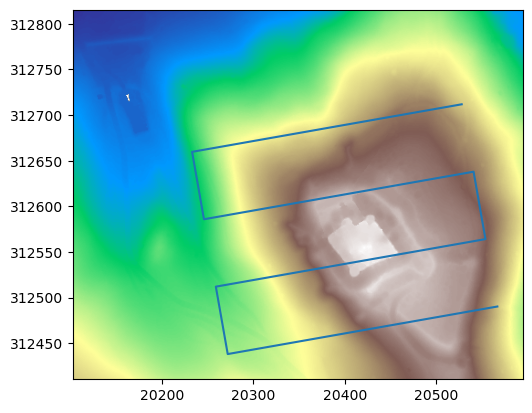

In [10]:
dtm, tf, bounds, origin_left, origin_bottom, origin_right, origin_top = helper_funcs.read_raster(terrain_sub)
plt.imshow(dtm, cmap="terrain", extent=[origin_left, origin_right, origin_bottom, origin_top])
plt.plot(waypoints_with_z[:, 0], waypoints_with_z[:, 1])
plt.show()

**Acquisition settings**

Now we configure the acquisition settings.

In [11]:
flight_v = 8  # velocity in m/s
pulse_freq = 200_000  # pulse frequency in Hz
scan_freq = 50  # scan frequency in Hz
scan_angle = 90  # scan angle in degrees

**Writing the survey file**

Now we can write the survey file, which is also an XML file. You can find further examples in the [HELIOS++ demo data folder](https://github.com/3dgeo-heidelberg/helios/tree/main/data/surveys).

In [12]:
legs = ""
for i in range(waypoints_with_z.shape[0]):
    x, y, z = waypoints_with_z[i]
    
    legs += f'''
    <leg>
            <platformSettings x="{x}" y="{y}" z="{z}" template="platform_uls"/>
            <scannerSettings template="scanner_uls" active="true"/>
    </leg>'''

Note how the survey below links to the `scanner` and `scene` that we defined earlier. 

In [13]:
survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
    <platformSettings id="platform_uls" movePerSec_m="{flight_v}"/>
    <scannerSettings active="true" id="scanner_uls" trajectoryTimeInterval_s="0.01" pulseFreq_hz="{pulse_freq}" scanAngle_deg="{scan_angle}" scanFreq_hz="{scan_freq}"/>
    <survey name="uls_survey" platform="data/platforms.xml#{platform}" scanner="data/scanners_als.xml#{scanner}" scene="{scene_file}#helios_scene">
    <FWFSettings beamSampleQuality="3" winSize_ns="1.5"/>
    {legs}
    </survey>
</document>
''' 

In [14]:
survey_file = "uls_StA_survey.xml"
with open(survey_file, 'w') as f:
    f.write(survey_content)

## 4. Running the simulation

In [15]:
pyhelios.loggingDefault()
simB = SimulationBuilder(str(survey_file), ['assets/'], 'helios_output/')
simB.setLasOutput(True)
simB.setZipOutput(True)

# build the simulation
sim = simB.build()

# Start the simulation.
start_time = time.time()
sim.start()

if sim.isStarted():
    print(f'Simulation has started!\nSurvey Name: {sim.sim.getSurvey().name}\n{sim.sim.getScanner().toString()}')

while sim.isRunning():
    duration = time.time()-start_time
    mins = duration // 60
    secs = duration % 60
    print('\r'+f'Simulation has been running for {int(mins)} min and {int(secs)} sec. Please wait.', end='')
    time.sleep(1)

if sim.isFinished():
    print('\n'+'Simulation has finished!')

output = sim.join()
meas, traj = pyhelios.outputToNumpy(output)

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 35.10048219999999 seconds
Simulation has started!
Survey Name: uls_survey
Scanner: riegl_vux-1uav22
Device[0]: riegl_vux-1uav22
	Average Power: 4 W
	Beam Divergence: 0.5 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 1 min and 37 sec. Please wait.
Simulation has finished!


## 5. Visualization

Using side views and top views, we visualise the simulated and real-world data to compare them.

In [16]:
# Load the real-world data
las = laspy.read("data/StA_last.laz")
ref = np.array([las.x, las.y, las.z]).T

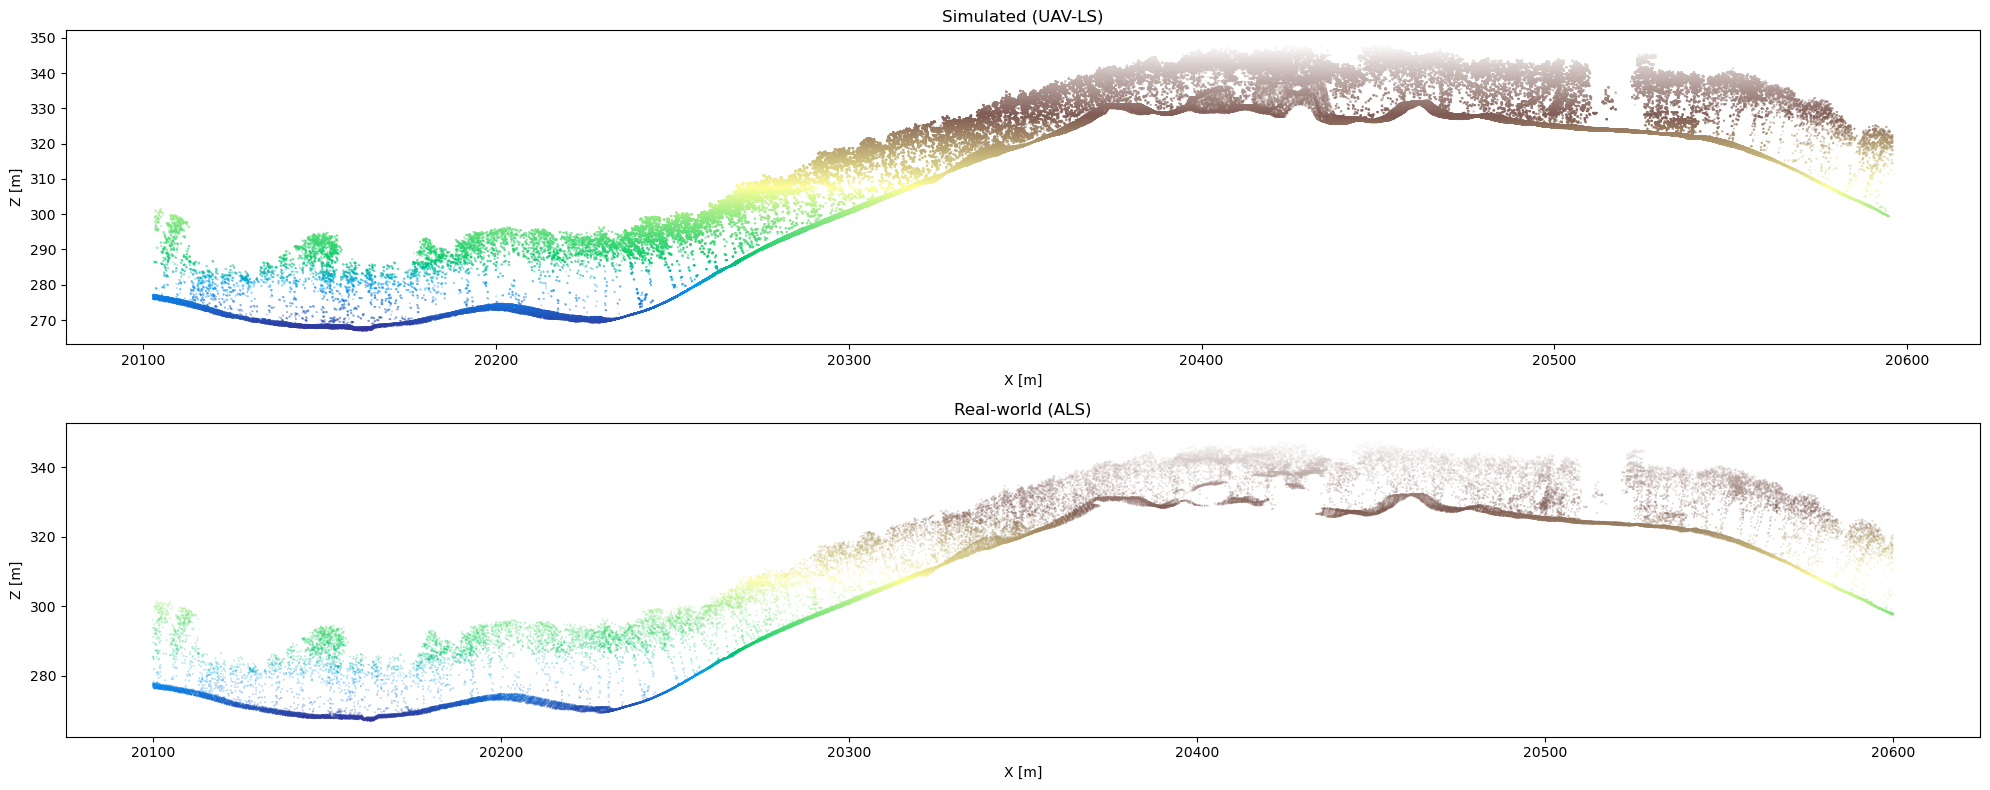

In [17]:
%matplotlib inline
# plotting a cross section
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

for pc, ax, title in zip([meas, ref], [ax1, ax2], ["Simulated (UAV-LS)", "Real-world (ALS)"]):
    idx = (pc[:, 1] > 312580) & (pc[:, 1] < 312590) & (pc[:, 0] > 20100) & (pc[:, 0] < 20600)
    ax.scatter(pc[idx, 0], pc[idx, 2], c=pc[idx, 2], s=0.02, cmap="terrain")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Z [m]")
    ax.set_title(title)
    ax.axis('equal')

plt.tight_layout()
plt.show()

The great thing about the simulation is that we have perfect reference data. Since we provided the ground and the vegetation separately, they receive different "object IDs". We can use this ID (stored in column 14 of our measurement array) to extract just the point clouds and visualize them.

These ground points could then also be used as reference testing different afwizard workflows for different datasets.

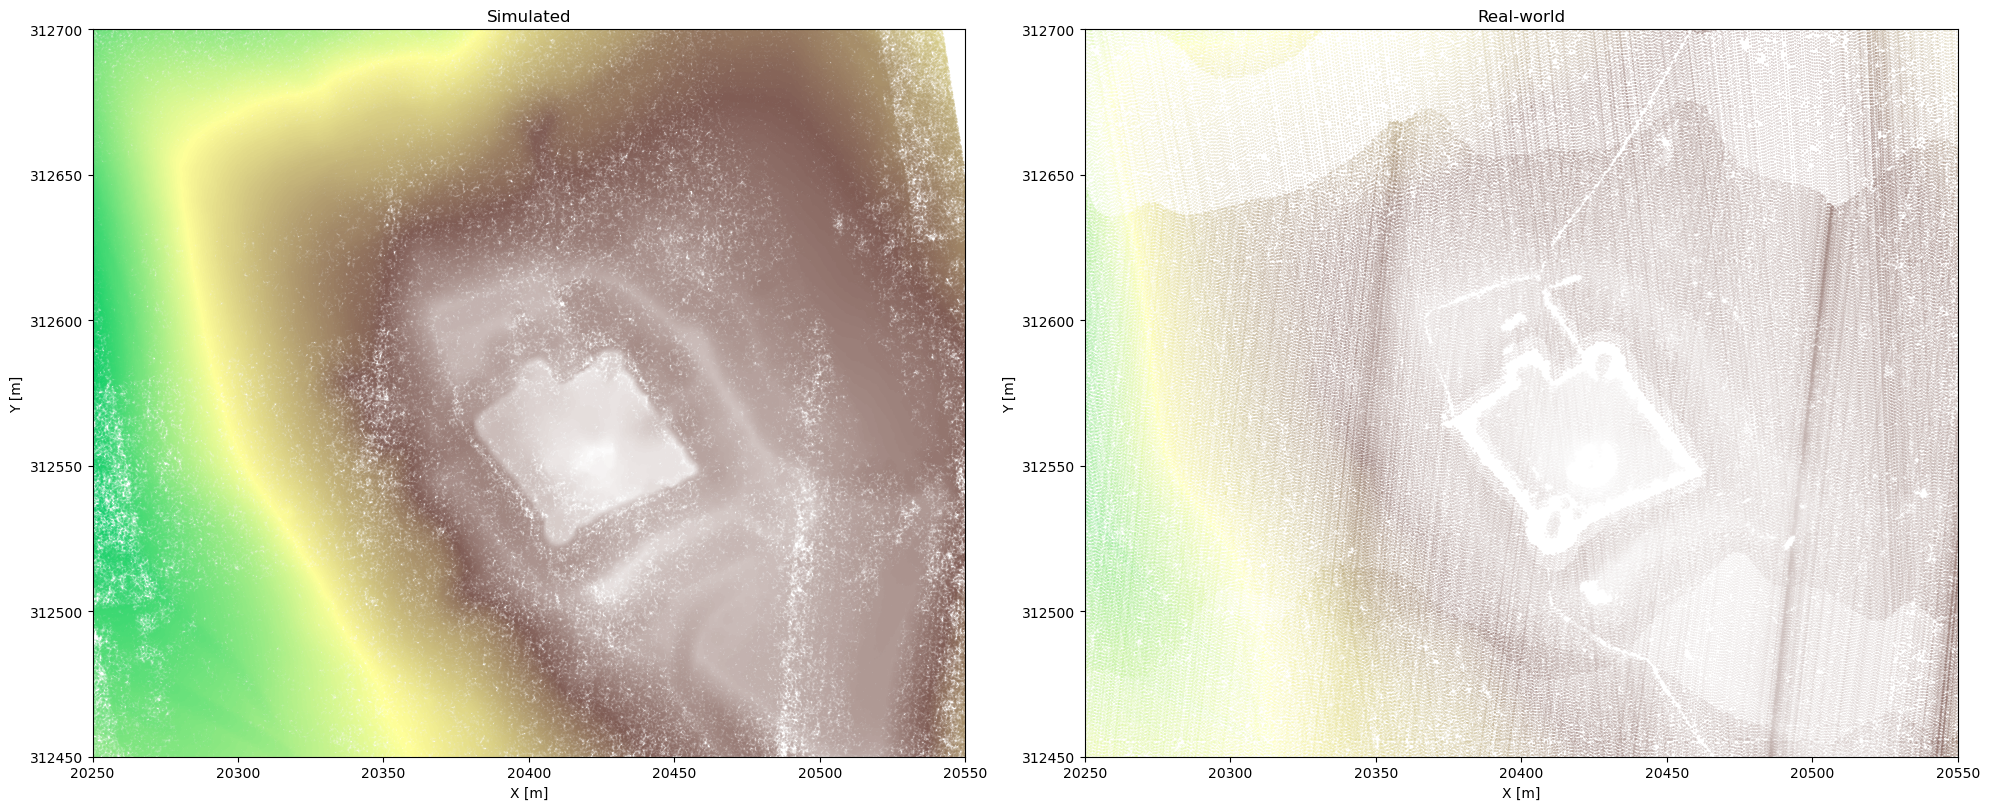

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
meas_ground = meas[meas[:, 14] == 0, :]  # extracting only ground points from simulated data
ref_ground = ref[las["classification"] == 2, :]  # extracting only ground points from real data

for pc, ax, title in zip([meas_ground, ref_ground], [ax1, ax2], ["Simulated", "Real-world"]):
    # We will only plot every 2nd point so it's faster
    ax.scatter(pc[::2, 0], pc[::2, 1], c=pc[::2, 2], s=0.02, cmap="terrain")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    ax.set_aspect("equal")
    ax.set_title(title)

plt.tight_layout()
plt.show()